In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [126]:
# Finds largest contour within bounding box
def findROIContour(thresh, bbox):
    bbox = map(int, bbox)
    x, y, w, h = bbox
    # ROI based off bounding box coordinates
    thresh_roi = thresh[y:y+h, x:x+w]
    # Mask of black pixels so only ROI is searched for contour
    mask = np.zeros((thresh.shape[0], thresh.shape[1]), np.uint8)
    mask[y:y+h, x:x+w] = thresh_roi
    
    # Taken from: https://stackoverflow.com/questions/54615166/find-the-biggest-contour-opencv-python-getting-errors
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours[0]]
    # If no contour, return None
    #print(contour_areas)
    if contour_areas is None or len(contour_areas)==0:
        final_c = [None, None]
    else:
        final_c = max(contour_areas, key=lambda x: x[0]) # Find largest contour in box
    return final_c[1]

# Find Centre coordinates of contour
def getContourMoment(contour):
    m = cv2.moments(contour)
    # Find Contour centre 
    x = m['m10'] / m['m00']
    y = m['m01'] / m['m00']
    return int(x), int(y) 

# Finds the full contour based on bounding box ROI
def findFullContour(thresh, centre):
    x, y = centre
    # Find all contours in image
    contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Return contour that centre belongs to
    for c in contours[0]:
        dist = cv2.pointPolygonTest(c, (x,y), False)
        if dist == 1.0:
            final_contour = c
            #print('Contour Found')
            #if cv2.contourArea(c) > size * 1.5:
            #    pass
            break
        else:
            final_contour = None
    #print(final_contour)
    return final_contour

# Fits a bounding box tightly around the contour
def getFittedBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return rect, box

# Converts a fitted bounding box to a straight one with no rotation 
def rotatedBoxConverter(box):
    box_t = np.array(box).T
    x, y = min(box_t[0]), min(box_t[1])
    w, h = max(box_t[0]) - x, max(box_t[1]) - y
    return x, y, w, h

In [155]:
waggle_df = pd.read_pickle('WaggleDanceTracker/WaggleDetections-Bees10(1).pkl')

In [157]:
df = waggle_df[waggle_df['Cluster']==1].reset_index()
df.head()

,level_0,index,x,y,frame,size,contour,Cluster
0,1,8,1055,396,2,330.0,"[[[1069, 350]], [[1070, 351]], [[1071, 351]], ...",1
1,4,17,1035,384,3,212.0,"[[[1025, 351]], [[1026, 352]], [[1027, 353]], ...",1
2,7,32,1049,396,5,348.0,"[[[1064, 371]], [[1063, 372]], [[1062, 373]], ...",1
3,8,33,1027,368,5,326.5,"[[[1017, 346]], [[1016, 347]], [[1016, 348]], ...",1
4,10,40,1066,381,6,603.5,"[[[1075, 352]], [[1075, 353]], [[1075, 354]], ...",1


In [129]:
length = df.iloc[-1, :]['frame'] - df.iloc[0, :]['frame'] 

### Remove Duplicates

In [131]:
# List of frames with multiple instances
duplicates = df[df['frame'].duplicated()]['frame'].values

for dup in duplicates:
    waggle = df[df['frame']==dup]
    prev_pt = df[df['frame']==dup-1]
    next_pt = df[df['frame']==dup+1]
    
    print(dup)

In [132]:
df

,x,y,frame,size,contour,Cluster
1233,1217,40,191,244.0,"[[[1235, 8]], [[1234, 9]], [[1233, 10]], [[123...",10
1248,1241,9,194,227.0,"[[[1234, 0]], [[1234, 1]], [[1234, 2]], [[1235...",10
1267,1215,32,196,190.5,"[[[1223, 16]], [[1222, 17]], [[1221, 17]], [[1...",10
1275,1220,21,197,271.0,"[[[1218, 0]], [[1218, 1]], [[1218, 2]], [[1218...",10
1284,1217,25,198,254.5,"[[[1218, 0]], [[1218, 1]], [[1218, 2]], [[1218...",10
1294,1216,25,199,321.5,"[[[1220, 0]], [[1220, 1]], [[1220, 2]], [[1220...",10
1304,1215,23,200,185.5,"[[[1220, 0]], [[1220, 1]], [[1220, 2]], [[1220...",10
1340,1214,25,206,180.5,"[[[1222, 0]], [[1222, 1]], [[1222, 2]], [[1222...",10
1344,1217,27,207,416.5,"[[[1222, 0]], [[1222, 1]], [[1222, 2]], [[1222...",10
1354,1219,27,208,263.5,"[[[1224, 0]], [[1224, 1]], [[1224, 2]], [[1224...",10


In [166]:
p = waggle_df[waggle_df['Cluster'] != -1].reset_index()
t = p[p.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster

In [167]:
p

,level_0,index,x,y,frame,size,contour,Cluster
0,0,2,1069,259,1,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0
1,1,8,1055,396,2,330.0,"[[[1069, 350]], [[1070, 351]], [[1071, 351]], ...",1
2,2,11,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
3,3,12,1041,250,2,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
4,4,17,1035,384,3,212.0,"[[[1025, 351]], [[1026, 352]], [[1027, 353]], ...",1
...,...,...,...,...,...,...,...,...
14448,14448,89405,1227,513,13611,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",511
14449,14449,89406,1202,495,13611,435.0,"[[[1193, 474]], [[1193, 475]], [[1194, 476]], ...",511
14450,14450,89412,1213,504,13612,920.0,"[[[1214, 465]], [[1213, 466]], [[1212, 466]], ...",511
14451,14451,89418,1200,493,13613,240.5,"[[[1217, 465]], [[1216, 466]], [[1215, 466]], ...",511


In [168]:
a = t.index.values
b = t.index.values - 1 # Rows before duplicate
c = t.index.values + 1 # Rows after duplicate

# Concatenate removing duplicate indices
idx = np.unique(np.concatenate((a, b, c)))

In [169]:
df = p[p.index.isin(idx)]
df.head()

,level_0,index,x,y,frame,size,contour,Cluster
1,1,8,1055,396,2,330.0,"[[[1069, 350]], [[1070, 351]], [[1071, 351]], ...",1
2,2,11,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
3,3,12,1041,250,2,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
4,4,17,1035,384,3,212.0,"[[[1025, 351]], [[1026, 352]], [[1027, 353]], ...",1
6,6,27,1079,255,4,249.0,"[[[1070, 233]], [[1069, 234]], [[1068, 234]], ...",0


### POSSIBLY 
Need to rearrange so the 'same_pts' match on cluster and frame

In [164]:
pts = df[['index', 'x','y','frame']].values

#pts = pts[np.argsort(pts[:, -1], axis = 0)]    # to sort about last column if not sorted
# Returns indices of duplicates
same_pts = [np.argwhere(i[0] == pts[:, -1]) for i in np.array(np.unique(pts[:, -1], return_counts=True)).T if i[1]>=2]
remove_row = []
for i in same_pts:
    dist = []
    pre = min(i)-1
    post = max(i)+1
    for j in i:
        # Euclidean distance from duplicate points and the point in the frame before and after 
        dist_pre = np.sqrt((pts[pre, 1]-pts[j, 1])**2 + (pts[pre, 2]-pts[j, 2])**2)
        dist_post = np.sqrt((pts[post, 1]-pts[j, 1])**2 + (pts[post, 2]-pts[j, 2])**2)
        dist.append(dist_pre + dist_post)
    remove_row.append(i[np.argmax(dist)][0])
final_pts = np.delete(pts, remove_row, axis = 0)

In [165]:
np.unique(pts[:, [-2, -1]])

array([  2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  14,  15,  19,
        20,  21,  22,  27,  28,  30,  33,  34,  35,  36,  39,  40,  58,
       361, 364, 366, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 396], dtype=int64)

In [137]:
df = df[df['index'].isin(final_pts[:, 0])]

In [139]:
df[df['Cluster'] == 1]

,index,x,y,frame,size,contour,Cluster
1,8,1055,396,3,330.0,"[[[1069, 350]], [[1070, 351]], [[1071, 351]], ...",1
4,17,1035,384,4,212.0,"[[[1025, 351]], [[1026, 352]], [[1027, 353]], ...",1
8,33,1027,368,6,326.5,"[[[1017, 346]], [[1016, 347]], [[1016, 348]], ...",1
11,41,1031,377,7,715.5,"[[[1021, 351]], [[1022, 352]], [[1023, 352]], ...",1
13,45,1034,379,8,553.5,"[[[1033, 356]], [[1034, 357]], [[1035, 358]], ...",1
14,46,1067,382,8,535.0,"[[[1077, 353]], [[1076, 354]], [[1076, 355]], ...",1
17,57,1047,382,10,655.0,"[[[1075, 349]], [[1075, 350]], [[1074, 351]], ...",1
20,66,1037,372,11,285.0,"[[[1036, 357]], [[1037, 358]], [[1038, 359]], ...",1
24,74,1038,369,12,229.5,"[[[1035, 357]], [[1036, 358]], [[1036, 359]], ...",1
31,94,1058,383,15,208.0,"[[[1081, 356]], [[1080, 357]], [[1079, 358]], ...",1


### Find Missing

In [146]:
clust = df[df['Cluster']==1].reset_index()

In [147]:
clust

,level_0,index,x,y,frame,size,contour,Cluster
0,1,8,1055,396,3,330.0,"[[[1069, 350]], [[1070, 351]], [[1071, 351]], ...",1
1,4,17,1035,384,4,212.0,"[[[1025, 351]], [[1026, 352]], [[1027, 353]], ...",1
2,8,33,1027,368,6,326.5,"[[[1017, 346]], [[1016, 347]], [[1016, 348]], ...",1
3,11,41,1031,377,7,715.5,"[[[1021, 351]], [[1022, 352]], [[1023, 352]], ...",1
4,13,45,1034,379,8,553.5,"[[[1033, 356]], [[1034, 357]], [[1035, 358]], ...",1
5,14,46,1067,382,8,535.0,"[[[1077, 353]], [[1076, 354]], [[1076, 355]], ...",1
6,17,57,1047,382,10,655.0,"[[[1075, 349]], [[1075, 350]], [[1074, 351]], ...",1
7,20,66,1037,372,11,285.0,"[[[1036, 357]], [[1037, 358]], [[1038, 359]], ...",1
8,24,74,1038,369,12,229.5,"[[[1035, 357]], [[1036, 358]], [[1036, 359]], ...",1
9,31,94,1058,383,15,208.0,"[[[1081, 356]], [[1080, 357]], [[1079, 358]], ...",1


In [141]:
cap = cv2.VideoCapture('Bees10.mov')

In [142]:
cap.set(1, clust.loc[0, 'frame'])
ret, frame = cap.read()
plt.figure(figsize=(20,10))
plt.imshow(frame)
plt.plot(clust.loc[0, 'x'], clust.loc[0, 'y'], marker='o', markersize=12)

KeyError: 0

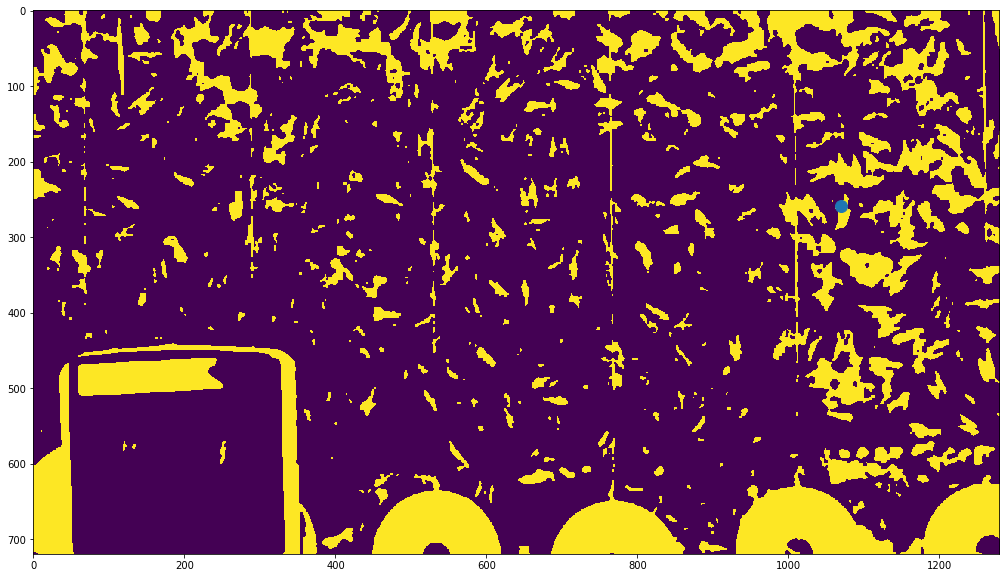

In [55]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
plt.figure(figsize=(20,10))
plt.imshow(opening)
plt.plot(clust.loc[0, 'x'], clust.loc[0, 'y'], marker='o', markersize=12)

In [60]:
x, y = clust.loc[0, 'x'], clust.loc[0, 'y']

box = x-10, y-10, 20, 20


contour = findROIContour(opening, box)
centre = getContourMoment(contour)

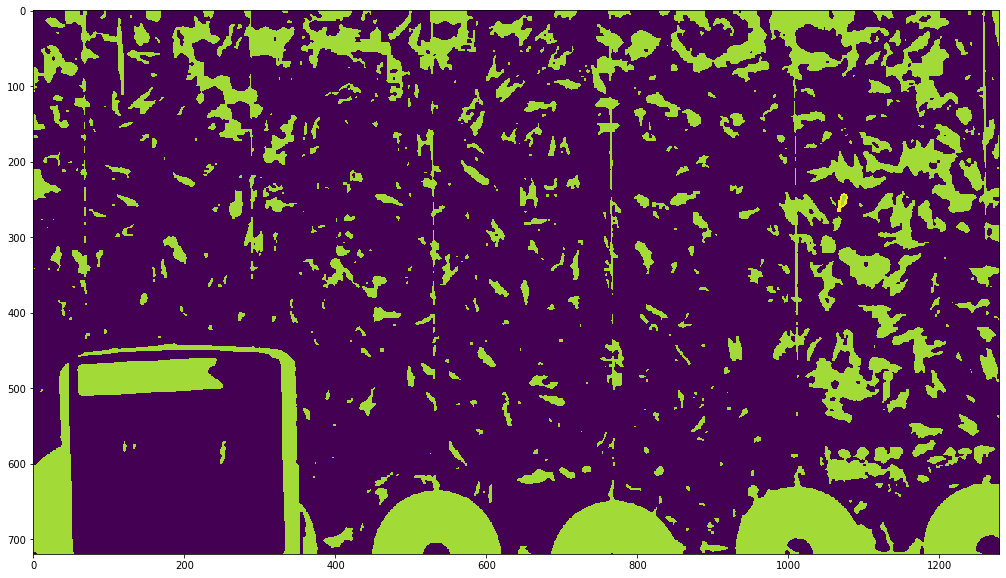

In [61]:
contour = findFullContour(opening, centre)
cv2.drawContours(opening, contour, -1, (255,0,0), 2, 1)
plt.figure(figsize=(20,10))
plt.imshow(opening)

In [62]:
rect, box = getFittedBox(contour)
bbox = rotatedBoxConverter(box)

(1063, 241, 15, 26)

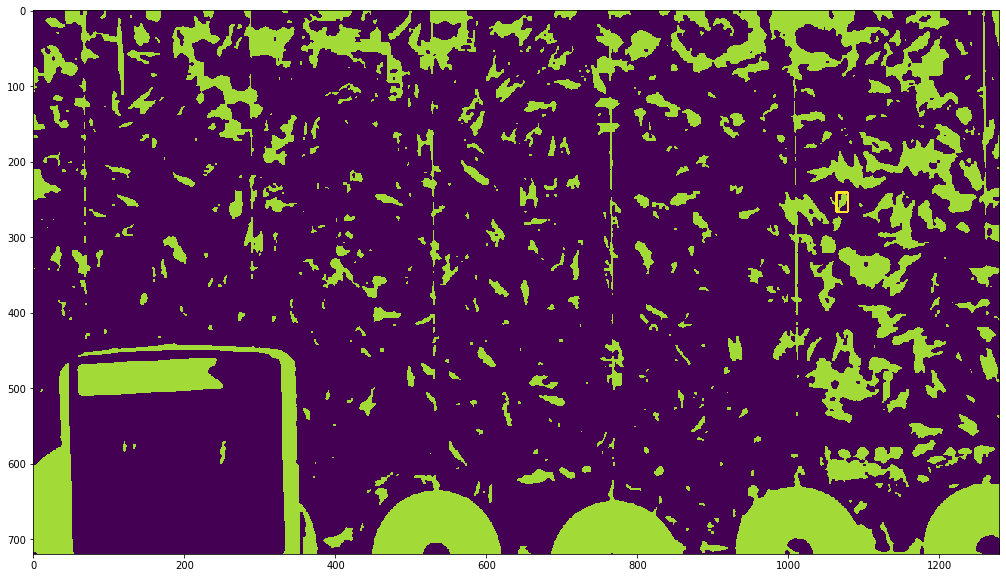

In [63]:
cap.set(1, df.loc[0, 'frame']+1)
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)

plt.figure(figsize=(20,10))
plt.imshow(opening)
bbox

In [64]:
tracker = cv2.TrackerCSRT_create()
tracker.init(frame, bbox)

cap.set(1, clust.loc[0, 'frame']+1)
ret, frame = cap.read()
ret, bbox = tracker.update(frame)
bbox

(1063.0101318359375, 241.0057830810547, 15.0, 26.0)

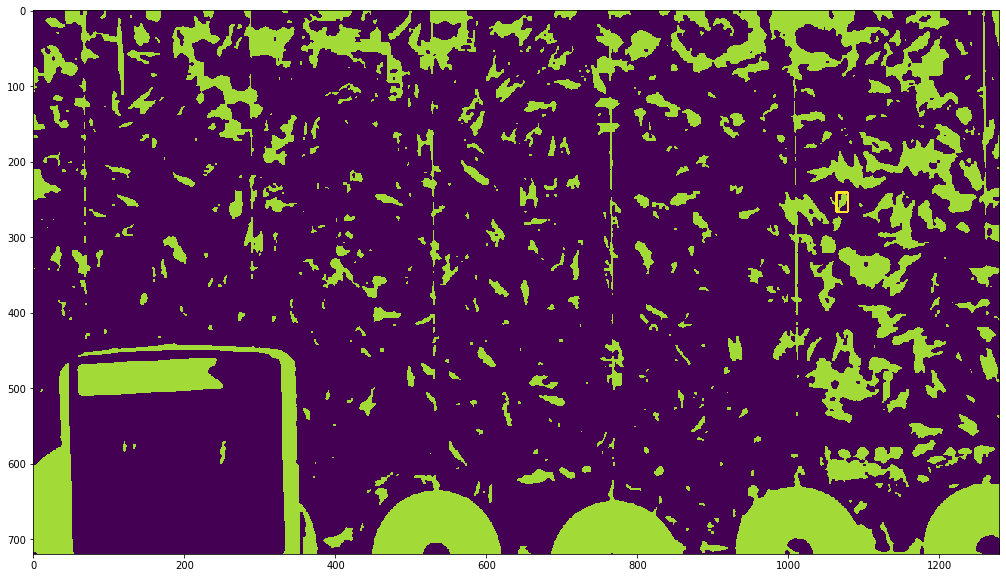

In [65]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)

plt.figure(figsize=(20,10))
plt.imshow(opening)

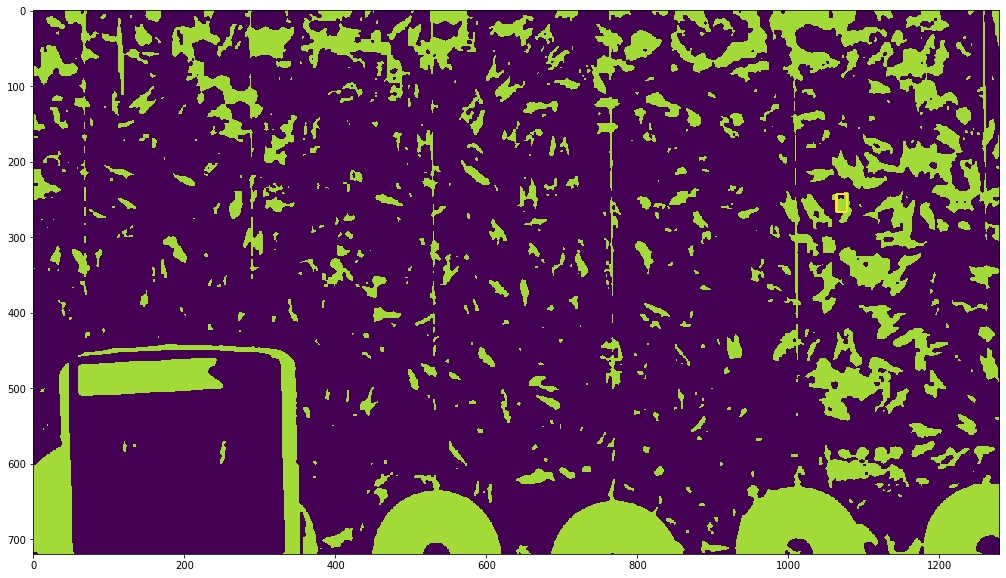

In [66]:
cap.set(1, clust.loc[0, 'frame']+2)
ret, frame = cap.read()
ret, bbox = tracker.update(frame)
bbox

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)

plt.figure(figsize=(20,10))
plt.imshow(opening)

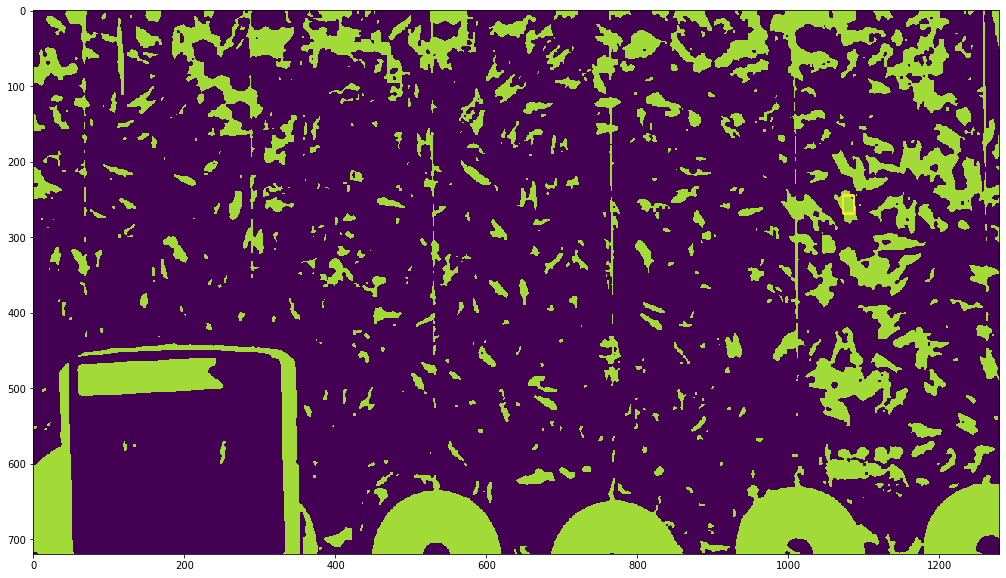

In [67]:
cap.set(1, clust.loc[0, 'frame']+3)
ret, frame = cap.read()
ret, bbox = tracker.update(frame)
bbox

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)

plt.figure(figsize=(20,10))
plt.imshow(opening)

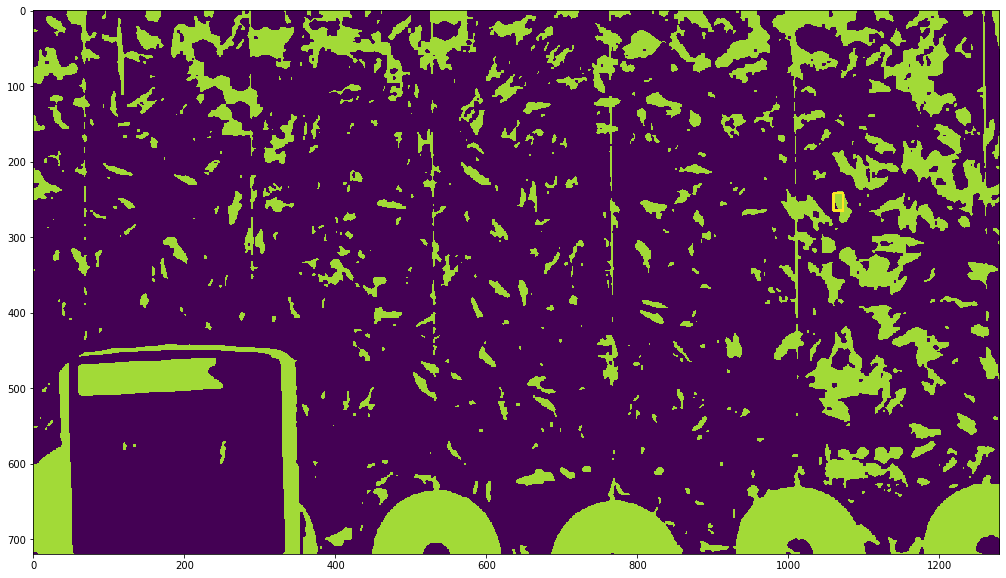

In [68]:
cap.set(1, clust.loc[0, 'frame']+4)
ret, frame = cap.read()
ret, bbox = tracker.update(frame)
bbox

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)

plt.figure(figsize=(20,10))
plt.imshow(opening)

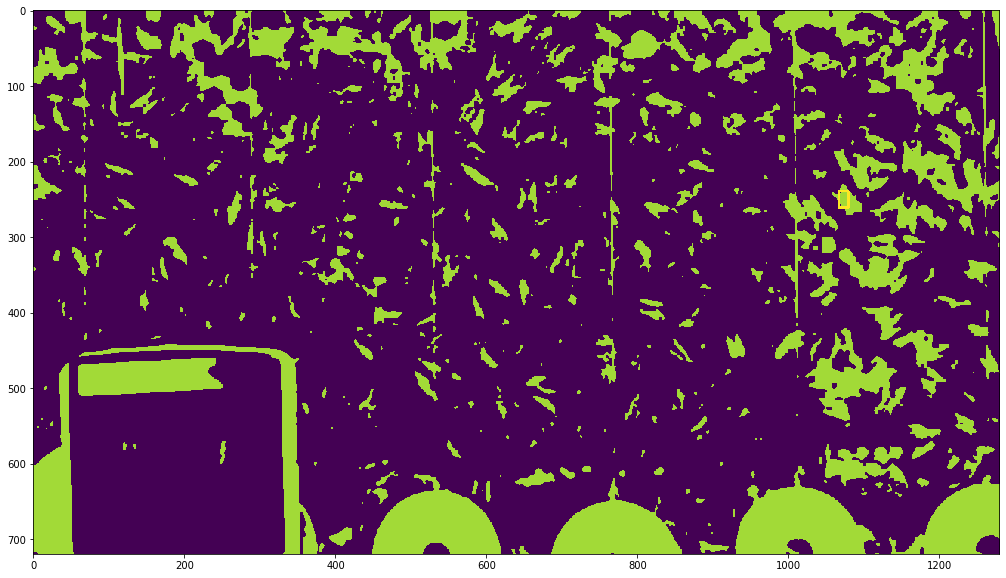

In [69]:
cap.set(1, clust.loc[0, 'frame']+5)
ret, frame = cap.read()
ret, bbox = tracker.update(frame)
bbox

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)

plt.figure(figsize=(20,10))
plt.imshow(opening)

Bring it together 

In [81]:
clust.head(20)

,index,x,y,frame,size,contour,Cluster
0,2,1069,259,2,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0
1,9,1076,261,3,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
3,14,1068,257,4,347.5,"[[[1053, 222]], [[1054, 223]], [[1055, 224]], ...",0
4,19,1079,255,5,249.0,"[[[1070, 233]], [[1069, 234]], [[1068, 234]], ...",0
6,37,1075,243,10,689.5,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0
7,44,1075,254,11,627.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0
10,51,1053,250,12,496.0,"[[[1051, 224]], [[1050, 225]], [[1049, 225]], ...",0
11,55,1064,246,13,1452.5,"[[[1051, 203]], [[1052, 203]], [[1053, 203]], ...",0
15,72,1058,241,19,1189.5,"[[[1043, 218]], [[1042, 219]], [[1041, 219]], ...",0
16,76,1076,240,20,304.0,"[[[1076, 229]], [[1075, 230]], [[1074, 230]], ...",0


In [82]:
clust.frame.values

array([ 2,  3,  4,  5, 10, 11, 12, 13, 19, 20, 21, 22, 45, 46, 47, 48],
      dtype=int64)

In [124]:
start = clust.loc[0, 'frame']
end = clust.iloc[-1, :]['frame']
# Get range of frames where waggle occurs
rang = np.arange(clust.loc[0, 'frame'], clust.iloc[-1, :]['frame'], 1)
missing = list(set(rang)-set(df.frame.values)) # Frames where waggle missing from df

counter = start - 1
cap.set(1, start - 1 )
ret, frame = cap.read()


# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)

# Find contour bounding box
x, y = clust.loc[0, 'x'], clust.loc[0, 'y']
box = x-10, y-10, 20, 20

contour = findROIContour(opening, box)
centre = getContourMoment(contour)
contour = findFullContour(opening, centre)
rect, box = getFittedBox(contour)
bbox = rotatedBoxConverter(box)

# Create tracker 
tracker = cv2.TrackerCSRT_create()
tracker.init(frame, bbox)

while counter < end:
    counter += 1 
    ret, frame = cap.read()
    
    # Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (15,15), 1)
    thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
    opening = cv2.erode(opening, kernel, iterations=1)

    if counter + 1 in missing:
        print('Missing')
        # update tracker
        ret, bbox = tracker.update(frame)
    
    else:
        # make bbox around contour and initialise tracker
        print('a')
        waggle = clust[clust['frame']==counter + 1].reset_index()
        # Add fix for if frame has multiple instances
        # If KNN is implemented to remove the outlier before this code, it will not be needed
        x, y = waggle.loc[0, 'x'], waggle.loc[0, 'y']
        bbox = x-10, y-10, 20, 20
        contour = findROIContour(opening, bbox)
        centre = getContourMoment(contour)
        contour = findFullContour(opening, centre)
        rect, box = getFittedBox(contour)
        bbox = rotatedBoxConverter(box)

    
    if counter not in missing and counter + 1 in missing:
        print('c')
        # find contour
        tracker = cv2.TrackerCSRT_create()
        tracker.init(frame, bbox)
    
    if ret:
    # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
        cv2.rectangle(thresh, p1, p2, (255, 0, 0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        
    cv2.imshow("Tracking", frame)
    cv2.imshow("Threshold", thresh)
    cv2.waitKey(1000)
    
    print(bbox)

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

a
(1060, 242, 22, 48)
a
(1063, 241, 15, 26)
a
(1056, 240, 30, 42)
Missing
c
(1070.899658203125, 235.0758056640625, 21.568628311157227, 45.09803771972656)
Missing
(1064.8057861328125, 236.37008666992188, 22.0, 45.0)
Missing
(1069.0594482421875, 227.4013214111328, 22.0, 45.0)
Missing
(1056.8602294921875, 230.72811889648438, 22.0, 45.0)
a
(1052, 227, 33, 46)
a
(989, 224, 82, 185)
a


ZeroDivisionError: float division by zero

# Combination of the above

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [102]:
# Finds largest contour within bounding box
def findROIContour(thresh, bbox):
    bbox = map(int, bbox)
    x, y, w, h = bbox
    # ROI based off bounding box coordinates
    thresh_roi = thresh[y:y+h, x:x+w]
    # Mask of black pixels so only ROI is searched for contour
    mask = np.zeros((thresh.shape[0], thresh.shape[1]), np.uint8)
    mask[y:y+h, x:x+w] = thresh_roi
    
    # Taken from: https://stackoverflow.com/questions/54615166/find-the-biggest-contour-opencv-python-getting-errors
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours[0]]
    # If no contour, return None
    #print(contour_areas)
    if contour_areas is None or len(contour_areas)==0:
        final_c = [None, None]
    else:
        final_c = max(contour_areas, key=lambda x: x[0]) # Find largest contour in box
    return final_c[1]

# Find Centre coordinates of contour
def getContourMoment(contour):
    m = cv2.moments(contour)
    # Find Contour centre 
    x = m['m10'] / m['m00']
    y = m['m01'] / m['m00']
    return int(x), int(y) 

# Finds the full contour based on bounding box ROI
def findFullContour(thresh, centre):
    x, y = centre
    # Find all contours in image
    contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # Return contour that centre belongs to
    for c in contours[0]:
        dist = cv2.pointPolygonTest(c, (x,y), False)
        if dist == 1.0:
            final_contour = c
            #print('Contour Found')
            #if cv2.contourArea(c) > size * 1.5:
            #    pass
            break
        else:
            final_contour = None
    #print(final_contour)
    return final_contour

# Fits a bounding box tightly around the contour
def getFittedBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return rect, box

# Converts a fitted bounding box to a straight one with no rotation 
def rotatedBoxConverter(box):
    box_t = np.array(box).T
    x, y = min(box_t[0]), min(box_t[1])
    w, h = max(box_t[0]) - x, max(box_t[1]) - y
    return x, y, w, h

In [193]:
waggle_df = pd.read_pickle('WaggleDetections-Bees10(1).pkl')
waggle_df.head()

,x,y,frame,size,contour,Cluster
0,1233,588,2,418.0,"[[[1249, 570]], [[1248, 571]], [[1247, 572]], ...",-1
1,1245,471,2,309.5,"[[[1218, 436]], [[1218, 437]], [[1219, 438]], ...",-1
2,1069,259,2,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0
3,1064,160,2,323.0,"[[[1071, 143]], [[1070, 144]], [[1069, 144]], ...",-1
4,1116,666,3,595.0,"[[[1115, 645]], [[1114, 646]], [[1113, 646]], ...",-1


In [183]:
df = waggle_df[waggle_df['Cluster'] != -1].reset_index()
dup = df[df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster

In [184]:
a = dup.index.values
b = dup.index.values - 1 # Rows before duplicate
c = dup.index.values + 1 # Rows after duplicate

# Concatenate removing duplicate indices
idx = np.unique(np.concatenate((a, b, c)))

df = df[df.index.isin(idx)]
df.head()

,level_0,index,x,y,frame,size,contour,Cluster
1,1,8,1055,396,2,330.0,"[[[1069, 350]], [[1070, 351]], [[1071, 351]], ...",1
2,2,11,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
3,3,12,1041,250,2,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
4,4,17,1035,384,3,212.0,"[[[1025, 351]], [[1026, 352]], [[1027, 353]], ...",1
6,6,27,1079,255,4,249.0,"[[[1070, 233]], [[1069, 234]], [[1068, 234]], ...",0


In [185]:
pts = df[['index', 'x', 'y', 'frame', 'Cluster']].values

In [186]:
pts = df[['index', 'x','y','frame']].values

#pts = pts[np.argsort(pts[:, -1], axis = 0)]    # to sort about last column if not sorted
# Returns indices of duplicates
same_pts = [np.argwhere(i[0] == pts[:, -1]) for i in np.array(np.unique(pts[:, -1], return_counts=True)).T if i[1]>=2]
remove_row = []
for i in same_pts:
    dist = []
    pre = min(i)-1
    post = max(i)+1
    for j in i:
        # Euclidean distance from duplicate points and the point in the frame before and after 
        dist_pre = np.sqrt((pts[pre, 1]-pts[j, 1])**2 + (pts[pre, 2]-pts[j, 2])**2)
        dist_post = np.sqrt((pts[post, 1]-pts[j, 1])**2 + (pts[post, 2]-pts[j, 2])**2)
        dist.append(dist_pre + dist_post)
    remove_row.append(i[np.argmax(dist)][0])
final_pts = np.delete(pts, remove_row, axis = 0)

In [191]:
np.array(np.unique(pts[:, [-2, -1]], return_counts=True))


array([[    2,     3,     4, ..., 13606, 13611, 13612],
       [    3,     1,     2, ...,     1,     2,     1]], dtype=int64)

In [192]:
np.array(np.unique(pts[:, -1], return_counts=True))

array([[    2,     3,     4, ..., 13606, 13611, 13612],
       [    3,     1,     1, ...,     1,     2,     1]], dtype=int64)

In [50]:
df = df[df['index'].isin(final_pts[:, 0])]